In [1]:
import numpy as np
import tqdm as tqdm

from tools._graphtools import *

In [2]:
def chain_ham(l,L,eps):
    mat = np.zeros((2*L,2*L))
    for i in range(0,L-1):
        mat[i,i+1] = mat[i+1,i] = 1
        mat[i+L,i+L+1] = mat[i+L+1,i+L] = 1

    mat[l,l+L] = mat[l+L,l] = eps
    return mat

In [42]:
adj = chain_ham(1,5,.1)

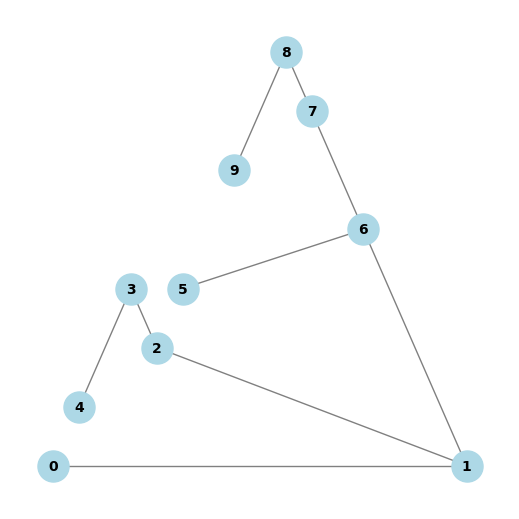

In [43]:
pl_adj(adj)

In [101]:
l= 1
eps = .01

probs = []
times = []

for L in range(5,201,10):    
    
    # Obtain the Hamiltonians for both cases
    ham = chain_ham(l,L,eps)
    # Define initial state and target state
    N = np.shape(ham)[0]
    psi_i = e_n(0, N)

    end_idx = L
    end = e_n(end_idx,N)

    # Define the time array over which evolution is evaluated
    t = np.linspace(0, 100*L, 1000)
    delta_t = t[1]
    U_bare = expm(-1j * ham * delta_t)


    prob_bare = [0]

    psi_curr_bare   = psi_i.copy()
    # Use tqdm to show progress for each time step
    for time in tqdm.tqdm(t[1:], desc=f"{L}: processing time steps", unit="time step"):
        psi_curr_bare = U_bare@psi_curr_bare
        prob_bare.append(np.abs(end.conj() @ psi_curr_bare)**2)

    times.append(t)
    probs.append(prob_bare)


195: processing time steps: 100%|██████████| 999/999 [00:00<00:00, 18582.32time step/s]


Text(0, 0.5, '$|\\langle 0 | e^{i H t} | L \\rangle$|')

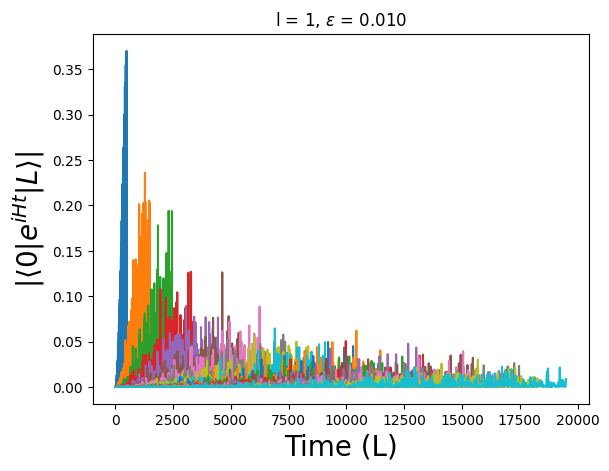

In [102]:
fs = 20

for i in range(len(probs)):
    plt.plot(times[i], probs[i],label="L = %d" %((i+1)*5))
#plt.legend(loc="upper right")
plt.title(r"l = %d, $\epsilon$ = %.3f" %(l, eps))
plt.xlabel("Time (L)",fontsize=fs)
plt.ylabel(r"$|\langle 0 | e^{i H t} | L \rangle$|",fontsize=fs)

In [103]:
def collect_maxes(arr, time_arr):
    maxes = [0]
    times = [0]
    for idx, elem in enumerate(arr):
        if elem > maxes[-1]:
            maxes.append(elem)
            times.append(time_arr[idx])
    return maxes,times

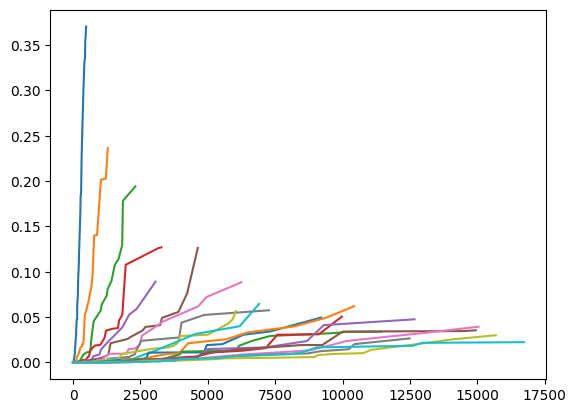

In [104]:
ms = []
ts = []

for i in range(len(probs)):
    m,t = collect_maxes(probs[i],times[i])
    ms.append(m)
    ts.append(t)
    plt.plot(t,m,label="L = %d" %((i+1)*5))

In [113]:
Ls = list(range(5,101,5))
# 1) Build x_eff and y_eff by concatenating all datasets
x_eff_list = []
y_eff_list = []

for i, L in enumerate(Ls):
    t_i = np.array(ts[i])         # shape = (n_i,)
    m_i = np.array(ms[i])         # shape = (n_i,)
    # “Effective x” = L * t
    x_eff_list.append(t_i/(L**2))
    y_eff_list.append(m_i)

# Now flatten them into one long vector
x_eff_all = np.concatenate(x_eff_list)   # shape = (sum of all n_i,)
y_eff_all = np.concatenate(y_eff_list)   # same shape

# 2) Solve for m_fit by the closed‐form least‐squares (no intercept):
#    m_fit = (X⋅Y)/(X⋅X)
numerator   = np.dot(x_eff_all, y_eff_all)
denominator = np.dot(x_eff_all, x_eff_all)
m_fit = numerator / denominator

print("Best‐fit m =", m_fit)


Best‐fit m = 0.016087913638987764


In [114]:
X = x_eff_all.reshape(-1, 1)     # shape = (N_pts, 1)
y = y_eff_all                    # shape = (N_pts,)

# np.linalg.lstsq returns [m_fit], residuals, rank, svals
m_fit_ls, *_ = np.linalg.lstsq(X, y, rcond=None)
m_fit = m_fit_ls[0]
print("m_fit via lstsq =", m_fit)

m_fit via lstsq = 0.016087913638987754


/var/folders/n7/sdrzr_l16mqf79r9kr85jqd80000gn/T/ipykernel_35491/1600364231.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


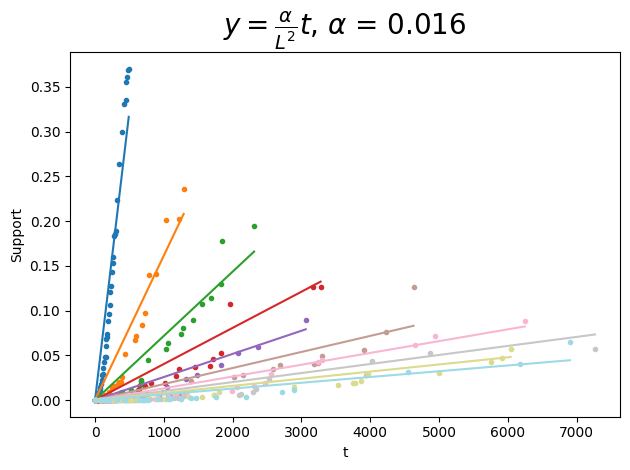

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def get_N_colors(N, cmap_name='tab20'):
    """
    Returns a list of N RGBA tuples sampled uniformly from the given colormap.

    Parameters:
      N         – number of colors to generate
      cmap_name – name of a Matplotlib colormap (e.g., 'tab10', 'tab20', 'viridis', etc.)

    Returns:
      List of length N, each entry is an (R, G, B, A) tuple.
    """
    cmap = plt.cm.get_cmap(cmap_name)
    # np.linspace(0, 1, N) creates N evenly spaced samples in [0,1]
    return [cmap(i) for i in np.linspace(0, 1, N)]

def plot_fitted_lines(ms, ts, Ls, show_data=True):
    """
    Fits m in the model y = m * L * t across multiple datasets,
    then plots the fitted lines (and optionally the raw data).

    Parameters
    ----------
    ms : list of 1D numpy arrays
        Each entry ms[i] holds the measured "m-values" for a given L = Ls[i].
    ts : list of 1D numpy arrays
        Each entry ts[i] holds the corresponding time array for L = Ls[i].
    Ls : 1D array-like of shape (n_datasets,)
        The list of L values (e.g., [5, 10, 15, ..., 50]) matching the order of ms/ts.
    show_data : bool, optional (default=True)
        If True, plot the raw (t, m) data points as scatter; 
        always plots the fitted line y = m_fit * L * t.

    Returns
    -------
    m_fit : float
        The best-fit proportionality constant.
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    ax : matplotlib.axes.Axes
        The axes object containing the plot.
    """

    # 1) Build big arrays x_eff_all and y_eff_all for the least-squares fit
    x_eff_list = []
    y_eff_list = []
    for i, L in enumerate(Ls):
        t_i = np.array(ts[i])         # shape = (n_i,)
        m_i = np.array(ms[i]) 
        x_eff_list.append(t_i/(L**2))
        y_eff_list.append(m_i)

    x_eff_all = np.concatenate(x_eff_list)
    y_eff_all = np.concatenate(y_eff_list)

    # 2) Closed-form least-squares for y = m_fit * x_eff
    numerator   = np.dot(x_eff_all, y_eff_all)
    denominator = np.dot(x_eff_all, x_eff_all)
    m_fit = numerator / denominator
    c = get_N_colors(len(Ls))
    # 3) Plotting
    fig, ax = plt.subplots()
    for i, L in enumerate(Ls[:10]):
        t_i = np.array(ts[i])
        m_i = np.array(ms[i])
        # Plot raw data if requested
        if show_data:
            ax.plot(t_i, m_i, '.', label=f"data, L={L}",color=c[i])
        # Plot fitted line
        ax.plot(t_i, m_fit/(L**2) * t_i, '-', label=f"fit, L={L}",color=c[i])

    ax.set_ylabel("Support")
    ax.set_xlabel("t")
    #ax.legend()
    ax.set_title(r"$y = \frac{\alpha}{L^2}t$, $\alpha$ = %.3f" %m_fit,fontsize=20)

    plt.tight_layout()
    return m_fit, fig, ax

# Example usage:
Ls = np.arange(5, 51, 5)
m_fit, fig, ax = plot_fitted_lines(ms, ts, Ls)
plt.show()




In [112]:
l= 1
eps = .01

probs = []
times = []

for L in range(5,101,5):    
    
    # Obtain the Hamiltonians for both cases
    ham = chain_ham(l,L,eps)
    # Define initial state and target state
    N = np.shape(ham)[0]
    psi_i = e_n(0, N)

    end_idx = L
    end = e_n(end_idx,N)

    # Define the time array over which evolution is evaluated
    t = np.linspace(0, 100**2, 2000)
    delta_t = t[1]
    U_bare = expm(-1j * ham * delta_t)


    prob_bare = [0]

    psi_curr_bare   = psi_i.copy()
    # Use tqdm to show progress for each time step
    for time in tqdm.tqdm(t[1:], desc=f"{L}: processing time steps", unit="time step"):
        psi_curr_bare = U_bare@psi_curr_bare
        prob_bare.append(np.abs(end.conj() @ psi_curr_bare)**2)

    times.append(t)
    probs.append(prob_bare)


100: processing time steps: 100%|██████████| 1999/1999 [00:00<00:00, 62828.13time step/s]


Text(0, 0.5, '$|\\langle 0 | e^{i H t} | L \\rangle$|')

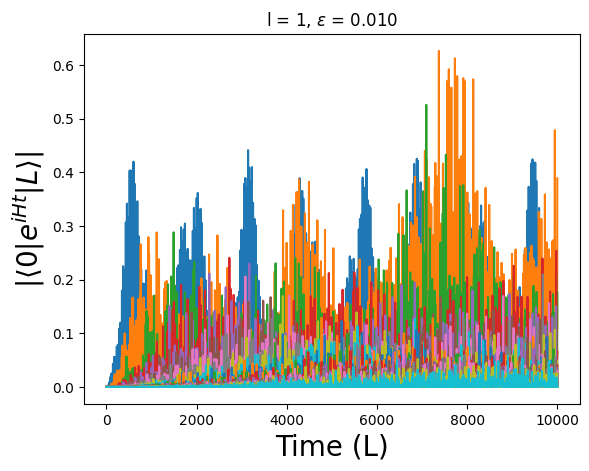

In [53]:
fs = 20

for i in range(len(probs)):
    plt.plot(times[i], probs[i],label="L = %d" %((i+1)*5))
#plt.legend(loc="upper left")
plt.title(r"l = %d, $\epsilon$ = %.3f" %(l, eps))
plt.xlabel("Time (L)",fontsize=fs)
plt.ylabel(r"$|\langle 0 | e^{i H t} | L \rangle$|",fontsize=fs)